# Short-term Temperature Model Test

## Import dependencies and data

In [ ]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [ ]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [ ]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('state', 'TA01_output'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('wind', 'Wx'),
    ('wind', 'Wy'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'hourofday'),
    ('time', 'date')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [ ]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

In [ ]:
# remove single NAN
data = data.dropna(how='any')

In [ ]:
# # reduce to one OBS per MIN
data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

data = data[data.index.get_level_values(0) != 4]

## Feature engineering

### GH Temperature

In [ ]:
### create "better" estimate of temperature var, w. proper avg.
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [ ]:
# adjust for setpoint change
col1 = ('temperatures', 'TA01_GT10X_GM10X')
# col2 = ('setpoints', 'TA01_GT10X_GM10X')
# data[col1] = data[col1] - data[col2]

# set min to zero
# data[col1] = data[col1] - abs(data[col1].min())

# scale by variance
# data[col1] = data[col1] / data[col1].std()

# # min-max scale, i.e. squeeze into [0, 1]
# data[col1] = (data[col1] - data[col1].min()) / (data[col1].max() - data[col1].min())


### DC temperature

In [ ]:
### min-max scale [btween 0 and 1]
col = ('temperatures', 'DC_GT401_GM401')
col2 = ('temperatures', 'DC_GT401_GM401_scaled')
# data[col] = (data[col] - data[col].mean()) / data[col].std()
# data[col] = data[col].apply(lambda val: max(val, 30)) # remove some extremely low temps to maintain variance in proper range
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())


### scale by fan output
# data[col2] = data[col] * data[('state', 'TA01_output')] / data[('state', 'TA01_output')].min()
data[col2] = data[col] * data[('flow', 'TA01_GP101')] / data[('flow', 'TA01_GP101')].min()

### OUTSIDE temperature

In [ ]:
### normalize vals
col = ('temperatures', 'DC_GT301_damped')
# data[col] = (data[col] - data[col].mean()) / data[col].std()

#min-max scale vals
#set MIN to zero
data[col] = data[col] + abs(data[col].min())
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### GH Humidity

In [ ]:
### create "better" estimate of temperature var, w. proper avg.
data[('humidity', 'TA01_GT10X_GM10X')] = data.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [ ]:
### normalize humidity
col = ('humidity', 'TA01_GT10X_GM10X')
# data[col] = (data[col] - data[col].mean()) / data[col].std()

# min-max scale vals
# data[col] = data[col] + data[col].mean()
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### Solar radiance

In [ ]:
# ### min-max scale GSI
col = ('sun', 'gsi')
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

# # variance scale GSI
# data[col] = data[col] / data[col].std()

# # create INDICATOR f. GSI
# data[('sun', 'gsi')] = data.sun.gsi.apply(lambda val: val > 1e-3)

In [ ]:
### min-max scale GSI deriv
col = ('sun', 'gsi_deriv')

data[col] = data[col] + abs(data[col].min())
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
# data[col] = data[col] / data[col].std()

In [ ]:
### min-max scale wind vars
col1 = ('wind', 'Wx')
col2 = ('wind', 'Wy')

data[col1] = data[col1] + abs(data[col1].min())
data[col1] = (data[col1] - data[col1].min()) / (data[col1].max() - data[col1].min())
data[col2] = data[col2] + abs(data[col2].min())
data[col2] = (data[col2] - data[col2].min()) / (data[col2].max() - data[col2].min())

# data[col] = data[col] / data[col].std()

### Flow volume

In [ ]:
### create INDICATOR variable f. TA01_output
data[('state', 'TA01_bool')] = data.state.TA01_output.apply(lambda val: val > 35)

In [ ]:
# # cap vals for transfer learning
# col = ('state', 'TA01_output')
# data[col] = data[col].apply(lambda val: min(val, 65))

In [ ]:
# ### ..
col = ('flow', 'TA01_GP101')
# col2 = ('flow', 'TA01_GP101_scaled')

# # create another version of flow
# data[col2] = data[col].copy()

# ### min-max scale flow (i.e. squeeze into [0, 1])
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

# ### min-max scale w.r.t. indicator variable
# mask = data[('state', 'TA01_output')].values
# data.loc[mask, col2] = (data[mask][col2] - data[mask][col2].min()) / (data[mask][col2].max() - data[mask][col2].min())
# data.loc[~mask, col2] = (data[~mask][col2] - data[~mask][col2].min()) / (data[~mask][col2].max() - data[~mask][col2].min())

## Kalman filtering

In [ ]:
cols = [
    (('temperatures', 'TA01_GT10X_GM10X'), 3),
    (('temperatures', 'DC_GT401_GM401'), 2),
    (('temperatures', 'DC_GT401_GM401_scaled'), 2),
    (('temperatures', 'DC_GT301_damped'), 4),
    (('humidity', 'TA01_GT10X_GM10X'), 3),
#     (('wind', 'Wx'), 3),
#     (('wind', 'Wy'), 3)
    
]

for colSpec in cols:
    # apply KALMAN filter to temperature measurements
    col = colSpec[0]
    varExp = colSpec[-1]
    
    # get data
    X = data[col].values
    n = len(X)

    # process variance, measurement variance
    Q = 1e-5
    R = 0.1**varExp

    xhat=np.zeros(n)      # a posteri estimate of x
    P=np.zeros(n)         # a posteri error estimate
    xhatminus=np.zeros(n) # a priori estimate of x
    Pminus=np.zeros(n)    # a priori error estimate
    K=np.zeros(n)         # gain or blending factor

    # intial guesses
    xhat[0] = X[0]
    P[0] = X[1]

    for k in range(1,n):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    data[col] = xhat

## Data preparation

In [ ]:
# t_steps = 10   # 10-min predictions
# n_steps = 60   # 60-min backwards look
# t_steps = 20   # 10-min predictions
# n_steps = 40   # 20-min backwards look

t_steps = 10
n_steps = 30

train_frac = 0.9

### Data selection and split

In [ ]:
# Define model variables
model_vars = [
    ('temperatures', 'TA01_GT10X_GM10X'),
#     ('flow', 'TA01_GP101'),
#     ('flow', 'TA01_GP101_scaled'),
#     ('state', 'TA01_output'),
#     ('state', 'TA01_bool'),
    ('temperatures', 'DC_GT401_GM401_scaled'),
#     ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
#     ('wind', 'Wx'),
#     ('wind', 'Wy'),
    ('time', 'minofday'),
    #('time', 'hourofday'),
    #('time', 'dayofyear'),
    #('time', 'monthofyear')
]

# filter data
testData = data[model_vars].copy()

In [ ]:
targets = testData.pop(('temperatures', 'TA01_GT10X_GM10X')).copy()
# auxData = targets.shift(n_steps).copy()
auxData = targets.shift(t_steps).copy()

# targets = (targets - targets.shift(t_steps)) * 10

### Create sequences

In [ ]:
def date_flagger(data, n_steps):
    # get flagged datesvalues
#     data['minute'] = data.index.get_level_values(3).values    
#     data['date_flag'] = data.minute - data.minute.shift(n_steps) != (n_steps)

    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [ ]:
# get all n_step-sequences from data series
vals = testData.values
# valsTemp = auxData.values

sequences = []
for i in range(len(testData) - n_steps):
    sequences.append(vals[i:i+n_steps])

# sequencesTemp = []
# for i in range(len(auxData) - (n_steps)):
#     sequencesTemp.append(valsTemp[i:i+(n_steps - t_steps)])

sequences = np.stack(sequences)
# sequencesTemp = np.stack(sequencesTemp)

In [ ]:
# get flagged sequences
flags = date_flagger(testData, n_steps)

# get mask f. flags
mask = [idx not in flags for idx in range(len(sequences))]
sequences = sequences[mask][:-t_steps]
# sequencesTemp = sequencesTemp[mask][n_steps:]

# get targets, delete mask
targets = targets.values[n_steps:][mask][:-t_steps]
auxData = auxData.values[n_steps:][mask][:-t_steps]

In [ ]:
# plt.plot(sequences[-100:, 0, 0])

In [ ]:
# fig, ax1 = plt.subplots()

# ax1.plot(targets[-100:])
# ax1.plot(auxData[-100:])

# ax2 = ax1.twinx()
# ax2.plot(sequences[-100:, -1, 0], 'b')

In [ ]:
# save sequential targets for visualization
targets, test_targets = targets[:-5760], targets[-5760:]
sequences, test_sequences = sequences[:-5760], sequences[-5760:]
auxData, test_auxData = auxData[:-5760], auxData[-5760:]
# seqsTemp, test_seqsTemp = sequencesTemp[:-5760], sequencesTemp[-5760:]

### Shuffle and split dataset

In [ ]:
# get random indices
idxs = np.arange(len(targets))
np.random.shuffle(idxs)

# shuffle sequences and targets
targets = np.squeeze(targets[idxs])
sequences = np.squeeze(sequences[idxs])
auxData = np.squeeze(auxData[idxs])
# seqsTemp = np.squeeze(seqsTemp[idxs])

In [ ]:
# split data
train_n = int(len(targets) * train_frac)

X_train, X_test = sequences[:train_n], sequences[train_n:]
# X_trainAux, X_testAux = seqsTemp[:train_n], seqsTemp[train_n:]
X_trainAux, X_testAux = auxData[:train_n], auxData[train_n:]
Y_train, Y_test = targets[:train_n], targets[train_n:]

In [ ]:
X_train = X_train.astype('float64')
# X_trainAux = X_trainAux.astype('float64')[:, :, np.newaxis]
X_trainAux = X_trainAux.astype('float64')
X_test = X_test.astype('float64')

## Define LSTM Regressor

In [ ]:
# # define LSTM env model
# inputsSeq = layers.Input(shape=(
#         X_train.shape[1],
#         X_train.shape[2]
# ))
# seqModel = layers.LSTM(
#         units=64,
#         activation='tanh',
#         return_sequences=True,
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         kernel_initializer=tf.keras.initializers.GlorotNormal(),
#         #dropout=0.2,
#         recurrent_dropout=0.2
# )(inputsSeq)
# seqModel = layers.BatchNormalization()(seqModel)
# seqModel = layers.LSTM(
#         units=32,
#         activation='tanh',
#         return_sequences=True,
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         kernel_initializer=tf.keras.initializers.GlorotNormal(),
#         #dropout=0.5,
#         recurrent_dropout=0.5
# )(seqModel)
# seqModel = layers.BatchNormalization()(seqModel)
# seqModel = layers.LSTM(
#         units=32,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         kernel_initializer=tf.keras.initializers.GlorotNormal(),
#         #dropout=0.5,
#         recurrent_dropout=0.5
# )(seqModel)
# seqModel = layers.BatchNormalization()(seqModel)
# seqModel = layers.Dense(
#         units=1,
#         activation=None,
#         activity_regularizer='l2',
#         kernel_initializer=tf.keras.initializers.GlorotNormal(),
# )(seqModel)
# seqModel = Model(
#     inputs=inputsSeq,
#     outputs=seqModel
# )

# # add temperature input w. Gaussian noise
# inputsTemp = layers.Input(shape=(1,))
# tempModel = layers.GaussianNoise(stddev=0.2)(inputsTemp)
# tempModel = Model(
#     inputs=inputsTemp,
#     outputs=tempModel
# )

# # combine inputs
# combModel = tf.add(
#     tf.divide(seqModel.output, 10), 
#     tempModel.output
# )
# model = Model(
#     inputs=[seqModel.input, tempModel.input],
#     outputs=combModel
# )

In [ ]:
# # lr = 0.005
# lr = 0.001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
# model.summary()

In [ ]:
# model2 = tf.keras.models.load_model(save_path + 'temp_diff_model_v51')
# model2.summary()

In [ ]:
# # copy weigths from pre-trained
# model.layers[1].set_weights(model2.layers[0].get_weights())
# model.layers[2].set_weights(model2.layers[1].get_weights())
# model.layers[3].set_weights(model2.layers[2].get_weights())
# model.layers[4].set_weights(model2.layers[3].get_weights())
# model.layers[5].set_weights(model2.layers[4].get_weights())
# model.layers[6].set_weights(model2.layers[5].get_weights())
# model.layers[7].set_weights(model2.layers[6].get_weights())

In [ ]:
# trainHist = model.fit(
#     [X_train, X_trainAux],
#     Y_train,
#     epochs=50,
#     batch_size=32,
#     validation_split=0.1,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
# #         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
#     ],
# )

In [ ]:
# model_name = 'temp_model_v10'
# model.save(save_path + model_name)

In [ ]:
model = tf.keras.models.load_model(save_path + 'temp_model_v10')
model.summary()

In [ ]:
preds = model.predict([X_test, X_testAux])
vis_preds = model.predict([
    test_sequences.astype('float64'), 
    test_auxData.astype('float64')
])

## Plot MAE

In [ ]:
test_mae = np.abs(np.squeeze(preds) - Y_test) 
temp_diffs = test_mae

In [ ]:
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[0, 1.0],
    kde=False,
    palette='bright',
    legend=False
)

plt.title('Distribution of errors for 10-minute forward predictions')
plt.xlim(0, 1.0)
plt.xlabel('$\Delta \\tau$ error, $^\circ$C')

plt.savefig(plot_path + 'temp_model_error_dist.png', bbox_inches='tight', dpi=200)
plt.show()

## Plot PREDS

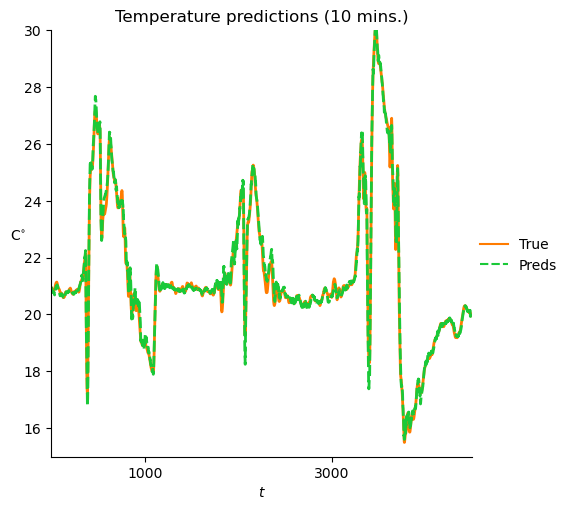

In [181]:
preds_df = pd.DataFrame(data=[test_targets, np.squeeze(vis_preds)]).T
preds_df.columns = ['True', 'Preds']
# preds_df.index = data.time.date.iloc[-5760:]

ax = sns.relplot(
    data=preds_df.iloc[:4500],
    kind='line',
    palette=sns.color_palette('bright')[1:3],
    linewidth=2.0,
    markers=False,
    dashes=True
)

ax.set_xticklabels(step=2)
plt.xlim(0, 4500)
plt.ylim(15, 30)
plt.xlabel('$t$')
plt.ylabel('C$^{\circ}$', rotation=0)
plt.title('Temperature predictions (10 mins.)')
# plt.savefig(plot_path + 'temp_model_preds.png', bbox_inches='tight', dpi=200)
plt.show()

## Test flow diffs

In [ ]:
preds = []
exp_seqs = test_sequences.copy().astype('float64')
exp_auxData = test_auxData.copy()
for idx, seq in enumerate(exp_seqs):
    if (idx % 500 == 0) and (idx > 0):
        print(idx)
    
    error = np.random.normal(loc=0.1, scale=0.02)
    
#     for n in range(n_steps-t_steps):
#         exp_seqs[idx+n, -(t_steps+n), 0] -= error

    seq[-t_steps:, 0] += error
    pred = model.predict([seq[np.newaxis, ...], exp_auxData[idx][np.newaxis, ...]], verbose=False)

    preds.append(pred[0][0])
    exp_auxData[idx + t_steps] = pred[0][0]
        

In [176]:
# get data
X = preds.copy()
n = len(X)

# process variance, measurement variance
Q = 1e-5
R = 0.1**3

xhat=np.zeros(n)      # a posteri estimate of x
P=np.zeros(n)         # a posteri error estimate
xhatminus=np.zeros(n) # a priori estimate of x
Pminus=np.zeros(n)    # a priori error estimate
K=np.zeros(n)         # gain or blending factor

# intial guesses
xhat[0] = X[0]
P[0] = X[1]

for k in range(1,n):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]


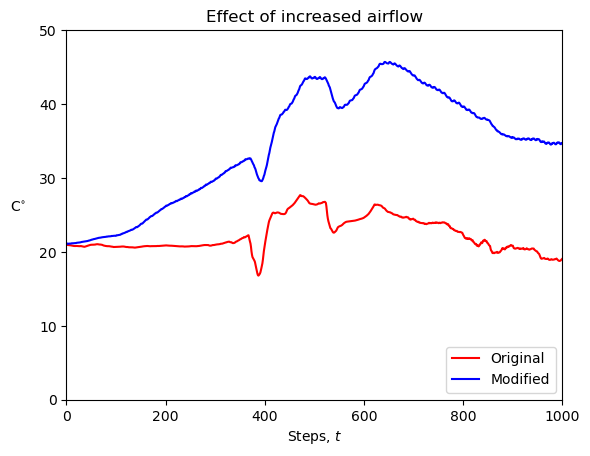

In [183]:
# plt.plot(preds[:200])
plt.plot(vis_preds[:1000], label='Original', c='r')
plt.plot(xhat[:1000], label='Modified', c='b')

plt.ylim(0, 50)
plt.xlim(0, 1000)

plt.xlabel('Steps, $t$')
plt.ylabel('C$^{\circ}$', rotation=0, labelpad=15)
plt.title('Effect of increased airflow')
plt.legend(loc='lower right')
# plt.savefig(plot_path + 'temp_pos_airflow.png', dpi=200)